In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    precision_recall_curve,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance
import shap
from sklearn.utils.class_weight import compute_class_weight

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-17 18:11:10.379576: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 18:11:10.419181: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 18:11:12.174586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_0818_variable.csv')
test = pd.read_csv('./data/test_0818_variable.csv')

In [5]:
train.columns

Index(['target', 'inconsistant', 'dist_head_stage1', 'dist_head_stage2',
       'dist_head_stage3', 'RESIN Adjusted_Predicted_Volume Stage1 Dam',
       'RESIN Adjusted_Predicted_Volume Stage2 Dam',
       'RESIN Adjusted_Predicted_Volume Stage3 Dam',
       'RESIN Adjusted_Predicted_Volume Stage1 Fill1',
       'RESIN Adjusted_Predicted_Volume Stage2 Fill1',
       'RESIN Adjusted_Predicted_Volume Stage3 Fill1', 'time_per_pressure_1st',
       'time_per_pressure_2nd', 'time_per_pressure_3rd', 'circle_stage1',
       'circle_stage2', 'circle_stage3', 'line_stage1', 'line_stage2',
       'line_stage3', 'cure_time_ratio_fill', 'cure_time_ratio_dam',
       'select_workorder', 'CURE SPEED Collect Result_Dam',
       'CURE SPEED Collect Result_Fill2', 'PalletID Collect Result_Dam',
       'Production Qty Collect Result_Dam',
       'Chamber Temp. Collect Result_AutoClave', 'model_suffix'],
      dtype='object')

In [6]:
# 학습시 inconsistant 전부 빼고 적용
train_sel = train[train['inconsistant'] == 0]

In [7]:
# 각 영역별 
stage1 = [
    'target', 'dist_head_stage1',
    'RESIN Adjusted_Predicted_Volume Stage1 Dam',
    'RESIN Adjusted_Predicted_Volume Stage1 Fill1', 'time_per_pressure_1st',
    'time_per_pressure_2nd', 'time_per_pressure_3rd', 'circle_stage1',
    'line_stage1', 'cure_time_ratio_fill', 'cure_time_ratio_dam',
    'select_workorder', 'CURE SPEED Collect Result_Dam',
    'CURE SPEED Collect Result_Fill2', 'PalletID Collect Result_Dam',
    'Production Qty Collect Result_Dam',
    'Chamber Temp. Collect Result_AutoClave', 'model_suffix'
]

stage2 = [
    'target', 'dist_head_stage2',
    'RESIN Adjusted_Predicted_Volume Stage2 Dam',
    'RESIN Adjusted_Predicted_Volume Stage2 Fill1',
    'time_per_pressure_1st',
    'time_per_pressure_2nd', 'time_per_pressure_3rd',
    'circle_stage2', 'line_stage2', 'cure_time_ratio_fill', 'cure_time_ratio_dam',
    'select_workorder', 'CURE SPEED Collect Result_Dam',
    'CURE SPEED Collect Result_Fill2', 'PalletID Collect Result_Dam',
    'Production Qty Collect Result_Dam',
    'Chamber Temp. Collect Result_AutoClave', 'model_suffix'
]

stage3 = [
    'target', 'dist_head_stage3', 
    'RESIN Adjusted_Predicted_Volume Stage3 Dam',
    'RESIN Adjusted_Predicted_Volume Stage3 Fill1', 'time_per_pressure_1st',
    'time_per_pressure_2nd', 'time_per_pressure_3rd', 'circle_stage3',
    'line_stage3', 'cure_time_ratio_fill', 'cure_time_ratio_dam',
    'select_workorder', 'CURE SPEED Collect Result_Dam',
    'CURE SPEED Collect Result_Fill2', 'PalletID Collect Result_Dam',
    'Production Qty Collect Result_Dam',
    'Chamber Temp. Collect Result_AutoClave', 'model_suffix'
]

df_stage1 = train_sel[stage1]
df_stage2 = train_sel[stage2]
df_stage3 = train_sel[stage3]

# Stage1

In [8]:
X_stage1 = df_stage1.drop(columns=['target'])
y_stage1 = df_stage1['target']

cat_features_indices_stage1 = ['model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage1, y_stage1, test_size=0.2, random_state=42, stratify = y_stage1)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage1)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage1)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
# Sampler 생성 시 random seed 설정
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-17 18:11:16,676] A new study created in memory with name: no-name-fee9d835-3ed1-4bcb-8f05-eb98161b443c
[I 2024-08-17 18:11:19,428] Trial 0 finished with value: 0.5454484337355511 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 0 with value: 0.5454484337355511.
[I 2024-08-17 18:11:22,592] Trial 1 finished with value: 0.5289831022664644 and parameters: {'iterations': 291, 'depth': 5, 'learning_rate': 0.0035498788321965025, 'l2_leaf_reg': 3.0493800071657815, 'border_count': 149, 'random_strength': 4.319450186989212, 'bagging_temperature': 0.2912291401980419, 'od_type': 'IncToDec', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 9}. Best is trial 0 with value: 0.5454484337355511.
[I 2024-08-17

[I 2024-08-17 18:14:17,037] Trial 19 finished with value: 0.5322656978174025 and parameters: {'iterations': 882, 'depth': 9, 'learning_rate': 0.005568783322854665, 'l2_leaf_reg': 6.724235829269183, 'border_count': 129, 'random_strength': 4.452755342353928, 'bagging_temperature': 0.5389531964951835, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Ordered', 'scale_pos_weight': 6}. Best is trial 14 with value: 0.5627969709095911.
[I 2024-08-17 18:14:20,675] Trial 20 finished with value: 0.559624056844532 and parameters: {'iterations': 1000, 'depth': 6, 'learning_rate': 0.1008313920573981, 'l2_leaf_reg': 4.917052482958943, 'border_count': 188, 'random_strength': 9.974698284812263, 'bagging_temperature': 0.6740203941531288, 'od_type': 'Iter', 'od_wait': 50, 'boosting_type': 'Ordered', 'scale_pos_weight': 7}. Best is trial 14 with value: 0.5627969709095911.
[I 2024-08-17 18:14:26,308] Trial 21 finished with value: 0.565048450866239 and parameters: {'iterations': 699, 'depth': 8, 'learnin

[I 2024-08-17 18:16:09,840] Trial 38 finished with value: 0.5556659056177141 and parameters: {'iterations': 624, 'depth': 6, 'learning_rate': 0.2584261214461031, 'l2_leaf_reg': 2.0914268316788687, 'border_count': 137, 'random_strength': 2.347405135002513, 'bagging_temperature': 0.6233761658532411, 'od_type': 'Iter', 'od_wait': 12, 'boosting_type': 'Plain', 'scale_pos_weight': 6}. Best is trial 32 with value: 0.571529506637679.
[I 2024-08-17 18:16:12,152] Trial 39 finished with value: 0.5423327475708932 and parameters: {'iterations': 856, 'depth': 7, 'learning_rate': 0.0645012764320946, 'l2_leaf_reg': 4.369049725410052, 'border_count': 164, 'random_strength': 1.3655569647693584, 'bagging_temperature': 0.6915899351767916, 'od_type': 'Iter', 'od_wait': 21, 'boosting_type': 'Plain', 'scale_pos_weight': 10}. Best is trial 32 with value: 0.571529506637679.
[I 2024-08-17 18:16:14,028] Trial 40 finished with value: 0.5405645022027118 and parameters: {'iterations': 713, 'depth': 5, 'learning_ra

Best trial:
  Value: 0.571529506637679
  Params: 
    iterations: 727
    depth: 7
    learning_rate: 0.03530642226942311
    l2_leaf_reg: 4.136485811753222
    border_count: 147
    random_strength: 3.1685633935900896
    bagging_temperature: 0.6337847240828516
    od_type: Iter
    od_wait: 20
    boosting_type: Plain
    scale_pos_weight: 7


In [9]:
study.best_trial.params

{'iterations': 727,
 'depth': 7,
 'learning_rate': 0.03530642226942311,
 'l2_leaf_reg': 4.136485811753222,
 'border_count': 147,
 'random_strength': 3.1685633935900896,
 'bagging_temperature': 0.6337847240828516,
 'od_type': 'Iter',
 'od_wait': 20,
 'boosting_type': 'Plain',
 'scale_pos_weight': 7}

In [10]:
# 최적의 하이퍼파라미터로 모델 재학습
stage1_best_params = study.best_trial.params
stage1_best_model = CatBoostClassifier(random_state = 42, **stage1_best_params)
stage1_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage1)

0:	learn: 0.6826152	total: 11.7ms	remaining: 8.52s
1:	learn: 0.6725070	total: 25.6ms	remaining: 9.28s
2:	learn: 0.6632661	total: 39.1ms	remaining: 9.43s
3:	learn: 0.6546859	total: 51.5ms	remaining: 9.32s
4:	learn: 0.6420877	total: 64.7ms	remaining: 9.34s
5:	learn: 0.6350533	total: 75.9ms	remaining: 9.12s
6:	learn: 0.6236026	total: 87ms	remaining: 8.95s
7:	learn: 0.6140317	total: 100ms	remaining: 9s
8:	learn: 0.6088985	total: 108ms	remaining: 8.65s
9:	learn: 0.6038975	total: 121ms	remaining: 8.67s
10:	learn: 0.5993536	total: 134ms	remaining: 8.7s
11:	learn: 0.5925474	total: 146ms	remaining: 8.73s
12:	learn: 0.5865529	total: 160ms	remaining: 8.78s
13:	learn: 0.5811526	total: 174ms	remaining: 8.85s
14:	learn: 0.5778502	total: 188ms	remaining: 8.9s
15:	learn: 0.5747741	total: 200ms	remaining: 8.91s
16:	learn: 0.5719209	total: 215ms	remaining: 8.96s
17:	learn: 0.5692601	total: 228ms	remaining: 8.98s
18:	learn: 0.5666380	total: 241ms	remaining: 8.98s
19:	learn: 0.5628404	total: 253ms	remaini

174:	learn: 0.5147370	total: 2.04s	remaining: 6.43s
175:	learn: 0.5146565	total: 2.05s	remaining: 6.42s
176:	learn: 0.5145599	total: 2.06s	remaining: 6.42s
177:	learn: 0.5145278	total: 2.08s	remaining: 6.41s
178:	learn: 0.5142987	total: 2.09s	remaining: 6.4s
179:	learn: 0.5142987	total: 2.1s	remaining: 6.37s
180:	learn: 0.5140220	total: 2.11s	remaining: 6.36s
181:	learn: 0.5139150	total: 2.12s	remaining: 6.35s
182:	learn: 0.5138790	total: 2.13s	remaining: 6.35s
183:	learn: 0.5136458	total: 2.15s	remaining: 6.34s
184:	learn: 0.5135095	total: 2.16s	remaining: 6.33s
185:	learn: 0.5134313	total: 2.17s	remaining: 6.32s
186:	learn: 0.5133257	total: 2.19s	remaining: 6.31s
187:	learn: 0.5131537	total: 2.2s	remaining: 6.3s
188:	learn: 0.5130694	total: 2.21s	remaining: 6.29s
189:	learn: 0.5129809	total: 2.22s	remaining: 6.28s
190:	learn: 0.5129141	total: 2.23s	remaining: 6.27s
191:	learn: 0.5127513	total: 2.25s	remaining: 6.26s
192:	learn: 0.5125523	total: 2.26s	remaining: 6.25s
193:	learn: 0.51

344:	learn: 0.4944598	total: 4.1s	remaining: 4.54s
345:	learn: 0.4941973	total: 4.11s	remaining: 4.53s
346:	learn: 0.4937717	total: 4.13s	remaining: 4.52s
347:	learn: 0.4934345	total: 4.14s	remaining: 4.51s
348:	learn: 0.4933208	total: 4.15s	remaining: 4.5s
349:	learn: 0.4932601	total: 4.16s	remaining: 4.49s
350:	learn: 0.4929024	total: 4.18s	remaining: 4.47s
351:	learn: 0.4925290	total: 4.19s	remaining: 4.46s
352:	learn: 0.4922820	total: 4.2s	remaining: 4.45s
353:	learn: 0.4920403	total: 4.22s	remaining: 4.44s
354:	learn: 0.4916648	total: 4.23s	remaining: 4.43s
355:	learn: 0.4913852	total: 4.24s	remaining: 4.42s
356:	learn: 0.4910759	total: 4.26s	remaining: 4.41s
357:	learn: 0.4908157	total: 4.27s	remaining: 4.4s
358:	learn: 0.4904453	total: 4.28s	remaining: 4.39s
359:	learn: 0.4902367	total: 4.3s	remaining: 4.38s
360:	learn: 0.4898333	total: 4.31s	remaining: 4.37s
361:	learn: 0.4894186	total: 4.32s	remaining: 4.36s
362:	learn: 0.4889997	total: 4.34s	remaining: 4.35s
363:	learn: 0.488

503:	learn: 0.4432328	total: 6.21s	remaining: 2.75s
504:	learn: 0.4429359	total: 6.23s	remaining: 2.74s
505:	learn: 0.4426135	total: 6.24s	remaining: 2.73s
506:	learn: 0.4423854	total: 6.25s	remaining: 2.71s
507:	learn: 0.4422191	total: 6.27s	remaining: 2.7s
508:	learn: 0.4419713	total: 6.28s	remaining: 2.69s
509:	learn: 0.4417587	total: 6.29s	remaining: 2.68s
510:	learn: 0.4414774	total: 6.31s	remaining: 2.67s
511:	learn: 0.4411125	total: 6.32s	remaining: 2.65s
512:	learn: 0.4407557	total: 6.34s	remaining: 2.64s
513:	learn: 0.4403809	total: 6.35s	remaining: 2.63s
514:	learn: 0.4401383	total: 6.36s	remaining: 2.62s
515:	learn: 0.4399133	total: 6.38s	remaining: 2.61s
516:	learn: 0.4395865	total: 6.39s	remaining: 2.59s
517:	learn: 0.4393488	total: 6.4s	remaining: 2.58s
518:	learn: 0.4390633	total: 6.42s	remaining: 2.57s
519:	learn: 0.4387075	total: 6.43s	remaining: 2.56s
520:	learn: 0.4384627	total: 6.44s	remaining: 2.55s
521:	learn: 0.4381272	total: 6.46s	remaining: 2.54s
522:	learn: 0.

670:	learn: 0.4018667	total: 8.46s	remaining: 706ms
671:	learn: 0.4015456	total: 8.47s	remaining: 693ms
672:	learn: 0.4013956	total: 8.48s	remaining: 681ms
673:	learn: 0.4011087	total: 8.5s	remaining: 668ms
674:	learn: 0.4007495	total: 8.51s	remaining: 656ms
675:	learn: 0.4004584	total: 8.53s	remaining: 643ms
676:	learn: 0.4002018	total: 8.54s	remaining: 631ms
677:	learn: 0.3999457	total: 8.55s	remaining: 618ms
678:	learn: 0.3996530	total: 8.56s	remaining: 605ms
679:	learn: 0.3993450	total: 8.58s	remaining: 593ms
680:	learn: 0.3992154	total: 8.59s	remaining: 580ms
681:	learn: 0.3990408	total: 8.6s	remaining: 568ms
682:	learn: 0.3989280	total: 8.62s	remaining: 555ms
683:	learn: 0.3986797	total: 8.63s	remaining: 543ms
684:	learn: 0.3985213	total: 8.64s	remaining: 530ms
685:	learn: 0.3982410	total: 8.66s	remaining: 518ms
686:	learn: 0.3979889	total: 8.67s	remaining: 505ms
687:	learn: 0.3978231	total: 8.69s	remaining: 492ms
688:	learn: 0.3976073	total: 8.7s	remaining: 480ms
689:	learn: 0.3

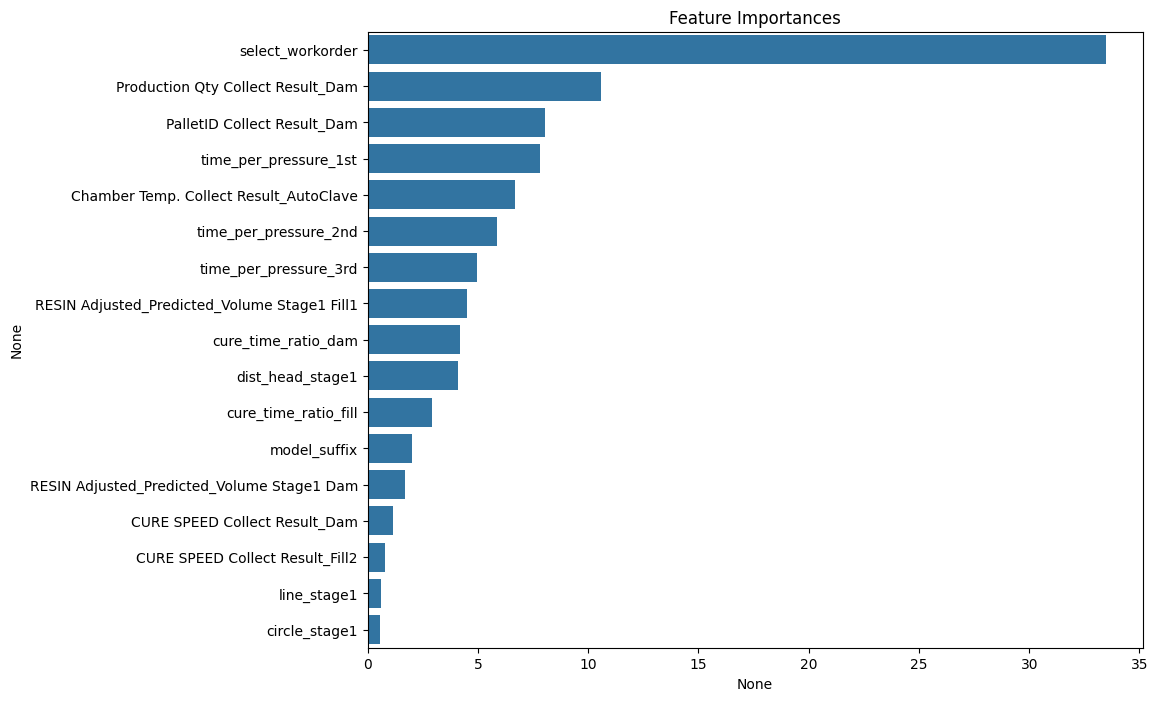

In [11]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage1_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [12]:
pred = stage1_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  89  362]
 [ 400 7232]]

정확도: 0.9057
정밀도: 0.1820
재현율: 0.1973
F1: 0.1894


In [13]:
# Precision - Recall
y_pred_proba = stage1_best_model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds_stage1 = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage1[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[ 155  296]
 [ 877 6755]]

정확도: 0.8549
정밀도: 0.1502
재현율: 0.3437
F1: 0.2090


In [14]:
cat_best_threshold

0.4193150485053925

# Stage2

In [15]:
X_stage2 = df_stage2.drop(columns=['target'])
y_stage2 = df_stage2['target']

cat_features_indices_stage2 = ['model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage2, y_stage2, test_size=0.2, random_state=42, stratify = y_stage2)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage2)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage2)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-17 18:17:26,689] A new study created in memory with name: no-name-49126c57-5836-438c-967a-f21d2d156deb
[I 2024-08-17 18:17:29,198] Trial 0 finished with value: 0.5161912158187308 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5161912158187308.
[I 2024-08-17 18:17:37,635] Trial 1 finished with value: 0.4901274784212227 and parameters: {'iterations': 850, 'depth': 5, 'learning_rate': 0.0035113563139704067, 'l2_leaf_reg': 1.8422110534358038, 'border_count': 100, 'random_strength': 5.247564316797622, 'bagging_temperature': 0.43194501864211576, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5161912158187308.
[I 2024-08-17 18:17:58,062] Trial 2 finished with value: 0.5076

[I 2024-08-17 18:18:53,535] Trial 20 finished with value: 0.5076518593564507 and parameters: {'iterations': 631, 'depth': 7, 'learning_rate': 0.06183720987189115, 'l2_leaf_reg': 6.820431388885036, 'border_count': 75, 'random_strength': 8.629450508811988, 'bagging_temperature': 0.9608771169328997, 'od_type': 'IncToDec', 'od_wait': 45, 'boosting_type': 'Plain'}. Best is trial 4 with value: 0.5223911838979458.
[I 2024-08-17 18:18:56,581] Trial 21 finished with value: 0.5161912158187308 and parameters: {'iterations': 348, 'depth': 4, 'learning_rate': 0.09781719499654107, 'l2_leaf_reg': 4.404640717831479, 'border_count': 50, 'random_strength': 6.212904037213901, 'bagging_temperature': 0.022088104792132628, 'od_type': 'IncToDec', 'od_wait': 36, 'boosting_type': 'Plain'}. Best is trial 4 with value: 0.5223911838979458.
[I 2024-08-17 18:18:57,623] Trial 22 finished with value: 0.5183034908832455 and parameters: {'iterations': 351, 'depth': 4, 'learning_rate': 0.4716945208154887, 'l2_leaf_reg':

[I 2024-08-17 18:19:29,203] Trial 40 finished with value: 0.514069973515344 and parameters: {'iterations': 339, 'depth': 6, 'learning_rate': 0.7226259021872445, 'l2_leaf_reg': 6.572298276725883, 'border_count': 46, 'random_strength': 7.42526191225549, 'bagging_temperature': 0.5673585667794205, 'od_type': 'IncToDec', 'od_wait': 13, 'boosting_type': 'Ordered'}. Best is trial 23 with value: 0.5245870865007138.
[I 2024-08-17 18:19:30,979] Trial 41 finished with value: 0.509800354171215 and parameters: {'iterations': 519, 'depth': 9, 'learning_rate': 0.13369444230342725, 'l2_leaf_reg': 7.621369943451427, 'border_count': 64, 'random_strength': 0.9545043767600263, 'bagging_temperature': 0.08012663867646638, 'od_type': 'IncToDec', 'od_wait': 47, 'boosting_type': 'Plain'}. Best is trial 23 with value: 0.5245870865007138.
[I 2024-08-17 18:19:31,847] Trial 42 finished with value: 0.514069973515344 and parameters: {'iterations': 482, 'depth': 4, 'learning_rate': 0.312254244603315, 'l2_leaf_reg': 5

Best trial:
  Value: 0.5280017659824687
  Params: 
    iterations: 204
    depth: 5
    learning_rate: 0.714686182011431
    l2_leaf_reg: 9.739550034968309
    border_count: 219
    random_strength: 2.745921072845561
    bagging_temperature: 0.37135429652121094
    od_type: Iter
    od_wait: 36
    boosting_type: Plain


In [16]:
study.best_trial.params

{'iterations': 204,
 'depth': 5,
 'learning_rate': 0.714686182011431,
 'l2_leaf_reg': 9.739550034968309,
 'border_count': 219,
 'random_strength': 2.745921072845561,
 'bagging_temperature': 0.37135429652121094,
 'od_type': 'Iter',
 'od_wait': 36,
 'boosting_type': 'Plain'}

In [17]:
# 최적의 하이퍼파라미터로 모델 재학습
stage2_best_params = study.best_trial.params
stage2_best_model = CatBoostClassifier(random_state = 42, **stage2_best_params)
stage2_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage2)

0:	learn: 0.2352021	total: 10.6ms	remaining: 2.16s
1:	learn: 0.2031181	total: 20.8ms	remaining: 2.1s
2:	learn: 0.1967799	total: 30.5ms	remaining: 2.04s
3:	learn: 0.1953517	total: 40.6ms	remaining: 2.03s
4:	learn: 0.1943163	total: 50.7ms	remaining: 2.02s
5:	learn: 0.1941200	total: 60.6ms	remaining: 2s
6:	learn: 0.1939046	total: 67.2ms	remaining: 1.89s
7:	learn: 0.1934695	total: 77ms	remaining: 1.89s
8:	learn: 0.1930920	total: 87.1ms	remaining: 1.89s
9:	learn: 0.1930369	total: 94.9ms	remaining: 1.84s
10:	learn: 0.1928213	total: 104ms	remaining: 1.83s
11:	learn: 0.1926604	total: 115ms	remaining: 1.83s
12:	learn: 0.1926466	total: 121ms	remaining: 1.77s
13:	learn: 0.1919686	total: 131ms	remaining: 1.78s
14:	learn: 0.1913765	total: 140ms	remaining: 1.77s
15:	learn: 0.1909525	total: 150ms	remaining: 1.76s
16:	learn: 0.1909118	total: 158ms	remaining: 1.74s
17:	learn: 0.1902051	total: 169ms	remaining: 1.75s
18:	learn: 0.1895453	total: 179ms	remaining: 1.75s
19:	learn: 0.1892756	total: 188ms	rem

164:	learn: 0.1502287	total: 1.62s	remaining: 384ms
165:	learn: 0.1500573	total: 1.64s	remaining: 374ms
166:	learn: 0.1498401	total: 1.65s	remaining: 365ms
167:	learn: 0.1496412	total: 1.66s	remaining: 355ms
168:	learn: 0.1495867	total: 1.67s	remaining: 345ms
169:	learn: 0.1492740	total: 1.68s	remaining: 335ms
170:	learn: 0.1492210	total: 1.69s	remaining: 325ms
171:	learn: 0.1489798	total: 1.7s	remaining: 316ms
172:	learn: 0.1489258	total: 1.71s	remaining: 306ms
173:	learn: 0.1485527	total: 1.72s	remaining: 296ms
174:	learn: 0.1483515	total: 1.73s	remaining: 286ms
175:	learn: 0.1480640	total: 1.74s	remaining: 276ms
176:	learn: 0.1476468	total: 1.75s	remaining: 266ms
177:	learn: 0.1472456	total: 1.76s	remaining: 257ms
178:	learn: 0.1472456	total: 1.76s	remaining: 246ms
179:	learn: 0.1469266	total: 1.77s	remaining: 236ms
180:	learn: 0.1467337	total: 1.78s	remaining: 227ms
181:	learn: 0.1465820	total: 1.79s	remaining: 217ms
182:	learn: 0.1465448	total: 1.8s	remaining: 207ms
183:	learn: 0.

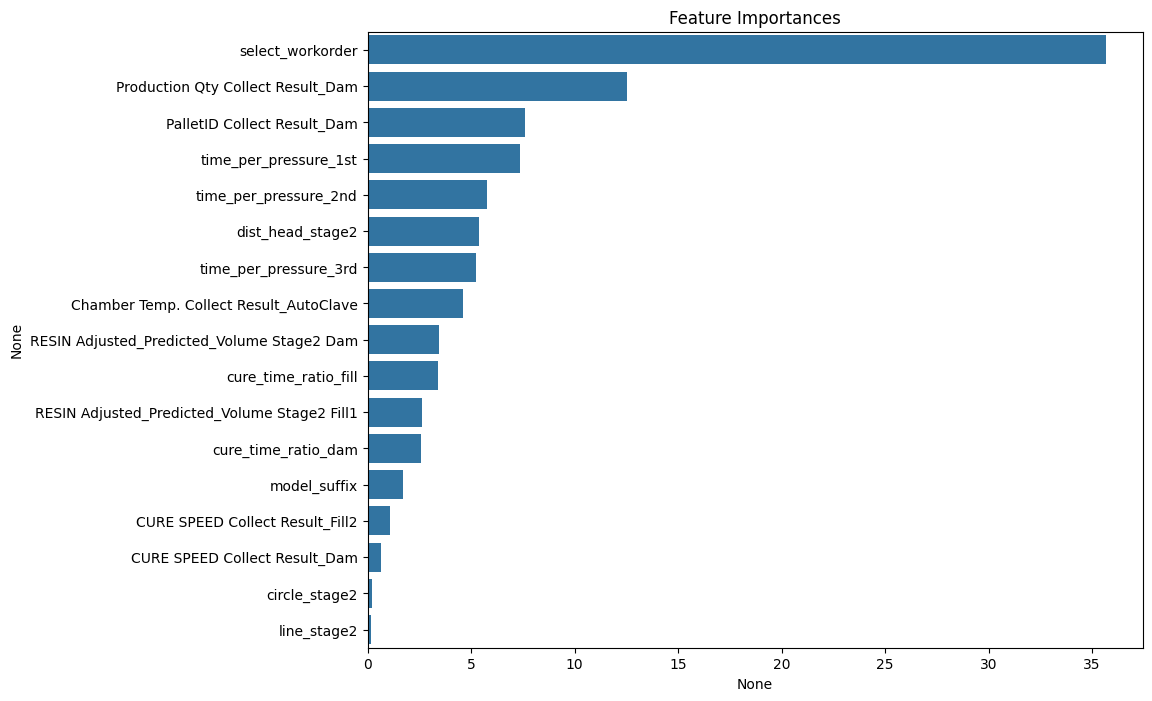

In [18]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage2_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [19]:
pred = stage2_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  26  425]
 [  25 7607]]

정확도: 0.9443
정밀도: 0.5098
재현율: 0.0576
F1: 0.1036


In [20]:
# Precision - Recall
y_pred_proba = stage2_best_model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds_stage2 = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage2[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[ 102  349]
 [ 499 7133]]

정확도: 0.8951
정밀도: 0.1697
재현율: 0.2262
F1: 0.1939


In [21]:
cat_best_threshold

0.15059491881163553

# Stage3

In [22]:
X_stage3 = df_stage3.drop(columns=['target'])
y_stage3 = df_stage3['target']

cat_features_indices_stage3 = ['model_suffix']

X_train, X_valid, y_train, y_valid = train_test_split(X_stage3, y_stage3, test_size=0.2, random_state=42, stratify = y_stage3)

train_pool = Pool(X_train, y_train, cat_features=cat_features_indices_stage3)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features_indices_stage3)

def objective(trial):
    # 하이퍼파라미터를 샘플링
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        "od_wait": trial.suggest_int("od_wait", 10, 50),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
#         "scale_pos_weight": trial.suggest_int('scale_pos_weight', 6, 10),
        'random_state': 42,
        "verbose": 0
    }
    
    # CatBoost 모델 학습
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)
    
    # 검증 세트에 대한 예측 및 평가
    preds = model.predict(X_valid)
    f1 = f1_score(y_valid, preds, average='macro')
    
    return f1

# Optuna 스터디 생성 및 최적화
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-08-17 18:19:45,500] A new study created in memory with name: no-name-55846391-1bda-4fc7-b67d-1e57e6c2b8f3
[I 2024-08-17 18:19:47,979] Trial 0 finished with value: 0.5161912158187308 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.15702970884055384, 'l2_leaf_reg': 5.990598257128395, 'border_count': 66, 'random_strength': 1.559945204206032, 'bagging_temperature': 0.05808361216819946, 'od_type': 'IncToDec', 'od_wait': 39, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5161912158187308.
[I 2024-08-17 18:19:56,315] Trial 1 finished with value: 0.4901274784212227 and parameters: {'iterations': 850, 'depth': 5, 'learning_rate': 0.0035113563139704067, 'l2_leaf_reg': 1.8422110534358038, 'border_count': 100, 'random_strength': 5.247564316797622, 'bagging_temperature': 0.43194501864211576, 'od_type': 'Iter', 'od_wait': 15, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.5161912158187308.
[I 2024-08-17 18:20:16,395] Trial 2 finished with value: 0.5076

[I 2024-08-17 18:21:06,766] Trial 20 finished with value: 0.5076518593564507 and parameters: {'iterations': 760, 'depth': 6, 'learning_rate': 0.019067594876368447, 'l2_leaf_reg': 9.914636380800225, 'border_count': 184, 'random_strength': 8.932881140715871, 'bagging_temperature': 0.9069186216472911, 'od_type': 'IncToDec', 'od_wait': 19, 'boosting_type': 'Plain'}. Best is trial 4 with value: 0.5203009148097695.
[I 2024-08-17 18:21:08,679] Trial 21 finished with value: 0.5076518593564507 and parameters: {'iterations': 495, 'depth': 10, 'learning_rate': 0.22854198839149392, 'l2_leaf_reg': 5.966957308343413, 'border_count': 71, 'random_strength': 2.0166406532094854, 'bagging_temperature': 0.2819694287405442, 'od_type': 'IncToDec', 'od_wait': 41, 'boosting_type': 'Plain'}. Best is trial 4 with value: 0.5203009148097695.
[I 2024-08-17 18:21:10,523] Trial 22 finished with value: 0.5204068563403635 and parameters: {'iterations': 319, 'depth': 10, 'learning_rate': 0.5256859930610427, 'l2_leaf_re

[I 2024-08-17 18:22:03,876] Trial 40 finished with value: 0.5076518593564507 and parameters: {'iterations': 410, 'depth': 9, 'learning_rate': 0.01148117507378634, 'l2_leaf_reg': 9.350409801266968, 'border_count': 75, 'random_strength': 0.10687445819472985, 'bagging_temperature': 0.39976692529574587, 'od_type': 'IncToDec', 'od_wait': 19, 'boosting_type': 'Ordered'}. Best is trial 22 with value: 0.5204068563403635.
[I 2024-08-17 18:22:06,367] Trial 41 finished with value: 0.509800354171215 and parameters: {'iterations': 455, 'depth': 10, 'learning_rate': 0.15794794355520525, 'l2_leaf_reg': 5.482979950836551, 'border_count': 252, 'random_strength': 1.3309010218463535, 'bagging_temperature': 0.24991909593868802, 'od_type': 'IncToDec', 'od_wait': 41, 'boosting_type': 'Plain'}. Best is trial 22 with value: 0.5204068563403635.
[I 2024-08-17 18:22:08,800] Trial 42 finished with value: 0.514069973515344 and parameters: {'iterations': 432, 'depth': 10, 'learning_rate': 0.16402162877682847, 'l2_l

Best trial:
  Value: 0.5204068563403635
  Params: 
    iterations: 319
    depth: 10
    learning_rate: 0.5256859930610427
    l2_leaf_reg: 5.9583793835958385
    border_count: 149
    random_strength: 2.1045540172963526
    bagging_temperature: 0.21292956743649316
    od_type: IncToDec
    od_wait: 43
    boosting_type: Plain


In [23]:
study.best_trial.params

{'iterations': 319,
 'depth': 10,
 'learning_rate': 0.5256859930610427,
 'l2_leaf_reg': 5.9583793835958385,
 'border_count': 149,
 'random_strength': 2.1045540172963526,
 'bagging_temperature': 0.21292956743649316,
 'od_type': 'IncToDec',
 'od_wait': 43,
 'boosting_type': 'Plain'}

In [24]:
# 최적의 하이퍼파라미터로 모델 재학습
stage3_best_params = study.best_trial.params
stage3_best_model = CatBoostClassifier(random_state = 42, **stage3_best_params)
stage3_best_model.fit(X_train, y_train, cat_features=cat_features_indices_stage3)

0:	learn: 0.2669021	total: 28.1ms	remaining: 8.93s
1:	learn: 0.2110387	total: 56ms	remaining: 8.88s
2:	learn: 0.1970585	total: 83.3ms	remaining: 8.77s
3:	learn: 0.1933083	total: 111ms	remaining: 8.72s
4:	learn: 0.1924164	total: 137ms	remaining: 8.62s
5:	learn: 0.1909414	total: 164ms	remaining: 8.54s
6:	learn: 0.1909301	total: 169ms	remaining: 7.55s
7:	learn: 0.1901814	total: 196ms	remaining: 7.61s
8:	learn: 0.1885901	total: 223ms	remaining: 7.69s
9:	learn: 0.1885282	total: 234ms	remaining: 7.22s
10:	learn: 0.1871315	total: 261ms	remaining: 7.31s
11:	learn: 0.1858384	total: 288ms	remaining: 7.38s
12:	learn: 0.1858379	total: 293ms	remaining: 6.9s
13:	learn: 0.1848056	total: 316ms	remaining: 6.89s
14:	learn: 0.1838734	total: 343ms	remaining: 6.94s
15:	learn: 0.1833787	total: 368ms	remaining: 6.97s
16:	learn: 0.1833123	total: 379ms	remaining: 6.73s
17:	learn: 0.1820900	total: 406ms	remaining: 6.78s
18:	learn: 0.1820657	total: 412ms	remaining: 6.5s
19:	learn: 0.1814171	total: 439ms	remainin

163:	learn: 0.0595116	total: 4.48s	remaining: 4.23s
164:	learn: 0.0592089	total: 4.5s	remaining: 4.2s
165:	learn: 0.0591243	total: 4.54s	remaining: 4.18s
166:	learn: 0.0586205	total: 4.56s	remaining: 4.15s
167:	learn: 0.0582877	total: 4.59s	remaining: 4.13s
168:	learn: 0.0580986	total: 4.62s	remaining: 4.1s
169:	learn: 0.0577029	total: 4.65s	remaining: 4.07s
170:	learn: 0.0575540	total: 4.67s	remaining: 4.04s
171:	learn: 0.0568766	total: 4.7s	remaining: 4.02s
172:	learn: 0.0564347	total: 4.73s	remaining: 3.99s
173:	learn: 0.0556993	total: 4.76s	remaining: 3.97s
174:	learn: 0.0552118	total: 4.79s	remaining: 3.94s
175:	learn: 0.0546486	total: 4.82s	remaining: 3.92s
176:	learn: 0.0545061	total: 4.85s	remaining: 3.89s
177:	learn: 0.0542013	total: 4.87s	remaining: 3.86s
178:	learn: 0.0534447	total: 4.9s	remaining: 3.83s
179:	learn: 0.0531419	total: 4.93s	remaining: 3.81s
180:	learn: 0.0530577	total: 4.96s	remaining: 3.78s
181:	learn: 0.0526860	total: 4.99s	remaining: 3.75s
182:	learn: 0.052

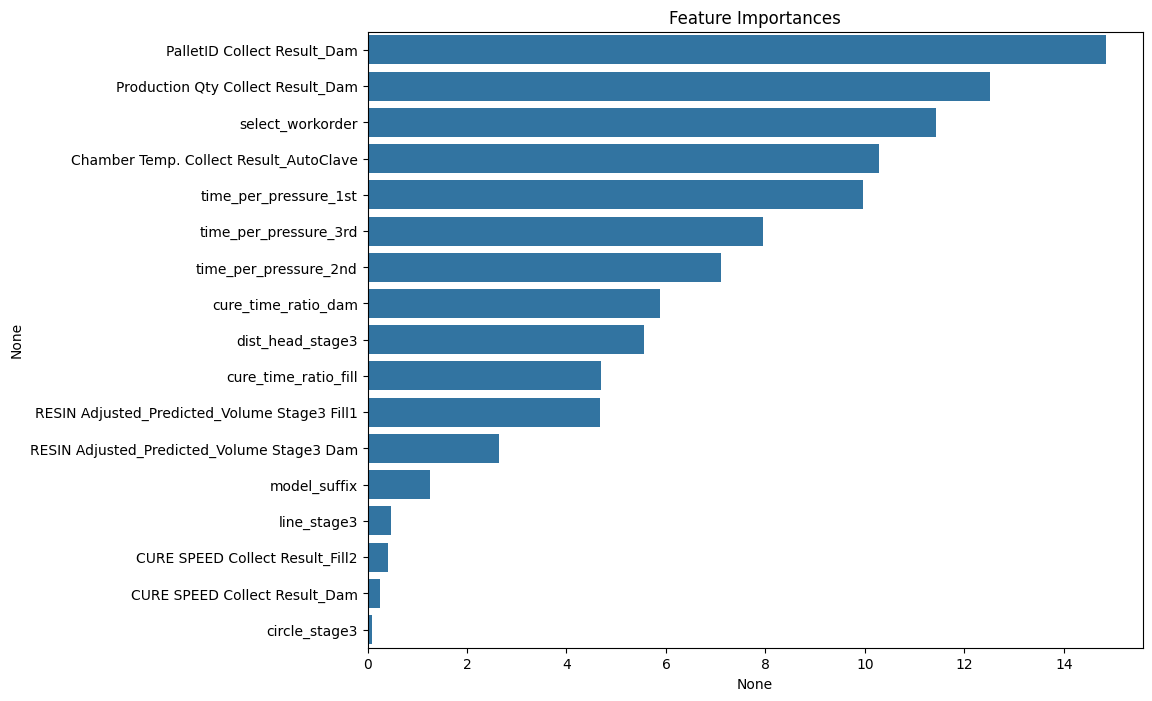

In [25]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(stage3_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [26]:
pred = stage3_best_model.predict(X_valid)
get_clf_eval(y_valid, pred)

오차행렬:
 [[  34  417]
 [  85 7547]]

정확도: 0.9379
정밀도: 0.2857
재현율: 0.0754
F1: 0.1193


In [27]:
# Precision - Recall
y_pred_proba = stage3_best_model.predict_proba(X_valid)[:, 1]

precision, recall, thresholds_stage3 = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage3[np.argmax(f1_scores)]
y_pred_custom_threshold = (y_pred_proba >= cat_best_threshold).astype(int)
get_clf_eval(y_valid, y_pred_custom_threshold)

오차행렬:
 [[ 114  337]
 [ 789 6843]]

정확도: 0.8607
정밀도: 0.1262
재현율: 0.2528
F1: 0.1684


In [28]:
cat_best_threshold

0.0665638326409587

# 민감성

In [29]:
# 최적의 하이퍼파라미터로 모델 재학습
stage1_best_params = stage1_best_params
stage1_best_model = CatBoostClassifier(random_state = 42, **stage1_best_params)
stage1_best_model.fit(X_stage1, y_stage1, cat_features=cat_features_indices_stage1)

# 최적의 하이퍼파라미터로 모델 재학습
stage2_best_params = stage2_best_params
stage2_best_model = CatBoostClassifier(random_state = 42, **stage2_best_params)
stage2_best_model.fit(X_stage2, y_stage2, cat_features=cat_features_indices_stage2)

# 최적의 하이퍼파라미터로 모델 재학습
stage3_best_params = stage3_best_params
stage3_best_model = CatBoostClassifier(random_state = 42, **stage3_best_params)
stage3_best_model.fit(X_stage3, y_stage3, cat_features=cat_features_indices_stage3)

0:	learn: 0.6772024	total: 16.8ms	remaining: 12.2s
1:	learn: 0.6678783	total: 25.5ms	remaining: 9.25s
2:	learn: 0.6586592	total: 41.7ms	remaining: 10.1s
3:	learn: 0.6460699	total: 56.9ms	remaining: 10.3s
4:	learn: 0.6345175	total: 71.6ms	remaining: 10.3s
5:	learn: 0.6278725	total: 86.8ms	remaining: 10.4s
6:	learn: 0.6218725	total: 95.2ms	remaining: 9.79s
7:	learn: 0.6158796	total: 110ms	remaining: 9.89s
8:	learn: 0.6077274	total: 127ms	remaining: 10.2s
9:	learn: 0.6026303	total: 143ms	remaining: 10.3s
10:	learn: 0.5977285	total: 159ms	remaining: 10.4s
11:	learn: 0.5937222	total: 168ms	remaining: 10s
12:	learn: 0.5895538	total: 184ms	remaining: 10.1s
13:	learn: 0.5861881	total: 192ms	remaining: 9.78s
14:	learn: 0.5828045	total: 207ms	remaining: 9.82s
15:	learn: 0.5797799	total: 222ms	remaining: 9.88s
16:	learn: 0.5777515	total: 238ms	remaining: 9.95s
17:	learn: 0.5723986	total: 252ms	remaining: 9.94s
18:	learn: 0.5698882	total: 268ms	remaining: 9.98s
19:	learn: 0.5676241	total: 280ms	re

161:	learn: 0.5180183	total: 2.25s	remaining: 7.83s
162:	learn: 0.5180180	total: 2.25s	remaining: 7.8s
163:	learn: 0.5179847	total: 2.27s	remaining: 7.79s
164:	learn: 0.5178332	total: 2.29s	remaining: 7.79s
165:	learn: 0.5177445	total: 2.3s	remaining: 7.78s
166:	learn: 0.5176368	total: 2.32s	remaining: 7.77s
167:	learn: 0.5176368	total: 2.32s	remaining: 7.73s
168:	learn: 0.5175299	total: 2.34s	remaining: 7.72s
169:	learn: 0.5174753	total: 2.35s	remaining: 7.71s
170:	learn: 0.5174246	total: 2.37s	remaining: 7.7s
171:	learn: 0.5174040	total: 2.38s	remaining: 7.67s
172:	learn: 0.5173564	total: 2.39s	remaining: 7.66s
173:	learn: 0.5172542	total: 2.41s	remaining: 7.66s
174:	learn: 0.5169197	total: 2.42s	remaining: 7.65s
175:	learn: 0.5168418	total: 2.44s	remaining: 7.64s
176:	learn: 0.5167158	total: 2.46s	remaining: 7.63s
177:	learn: 0.5166417	total: 2.47s	remaining: 7.62s
178:	learn: 0.5166198	total: 2.48s	remaining: 7.61s
179:	learn: 0.5165062	total: 2.5s	remaining: 7.6s
180:	learn: 0.516

324:	learn: 0.5036406	total: 4.54s	remaining: 5.62s
325:	learn: 0.5034199	total: 4.56s	remaining: 5.61s
326:	learn: 0.5032082	total: 4.57s	remaining: 5.6s
327:	learn: 0.5031676	total: 4.58s	remaining: 5.58s
328:	learn: 0.5031676	total: 4.59s	remaining: 5.55s
329:	learn: 0.5031676	total: 4.6s	remaining: 5.53s
330:	learn: 0.5031401	total: 4.61s	remaining: 5.51s
331:	learn: 0.5030112	total: 4.63s	remaining: 5.5s
332:	learn: 0.5028922	total: 4.64s	remaining: 5.49s
333:	learn: 0.5027630	total: 4.66s	remaining: 5.48s
334:	learn: 0.5026729	total: 4.67s	remaining: 5.46s
335:	learn: 0.5024775	total: 4.69s	remaining: 5.45s
336:	learn: 0.5022502	total: 4.7s	remaining: 5.44s
337:	learn: 0.5022188	total: 4.71s	remaining: 5.43s
338:	learn: 0.5020534	total: 4.73s	remaining: 5.42s
339:	learn: 0.5017792	total: 4.75s	remaining: 5.41s
340:	learn: 0.5014914	total: 4.76s	remaining: 5.39s
341:	learn: 0.5012131	total: 4.78s	remaining: 5.38s
342:	learn: 0.5011753	total: 4.79s	remaining: 5.36s
343:	learn: 0.50

483:	learn: 0.4630256	total: 7.04s	remaining: 3.53s
484:	learn: 0.4627982	total: 7.05s	remaining: 3.52s
485:	learn: 0.4625996	total: 7.07s	remaining: 3.51s
486:	learn: 0.4623457	total: 7.09s	remaining: 3.49s
487:	learn: 0.4620375	total: 7.1s	remaining: 3.48s
488:	learn: 0.4617967	total: 7.12s	remaining: 3.46s
489:	learn: 0.4614347	total: 7.14s	remaining: 3.45s
490:	learn: 0.4612520	total: 7.15s	remaining: 3.44s
491:	learn: 0.4610452	total: 7.17s	remaining: 3.42s
492:	learn: 0.4607468	total: 7.18s	remaining: 3.41s
493:	learn: 0.4604802	total: 7.2s	remaining: 3.4s
494:	learn: 0.4603579	total: 7.22s	remaining: 3.38s
495:	learn: 0.4600687	total: 7.23s	remaining: 3.37s
496:	learn: 0.4598344	total: 7.25s	remaining: 3.35s
497:	learn: 0.4595921	total: 7.27s	remaining: 3.34s
498:	learn: 0.4594212	total: 7.28s	remaining: 3.33s
499:	learn: 0.4591747	total: 7.3s	remaining: 3.31s
500:	learn: 0.4589400	total: 7.32s	remaining: 3.3s
501:	learn: 0.4587170	total: 7.33s	remaining: 3.29s
502:	learn: 0.458

643:	learn: 0.4284335	total: 9.61s	remaining: 1.24s
644:	learn: 0.4282929	total: 9.62s	remaining: 1.22s
645:	learn: 0.4280621	total: 9.64s	remaining: 1.21s
646:	learn: 0.4278570	total: 9.65s	remaining: 1.19s
647:	learn: 0.4277681	total: 9.67s	remaining: 1.18s
648:	learn: 0.4275718	total: 9.69s	remaining: 1.16s
649:	learn: 0.4273082	total: 9.7s	remaining: 1.15s
650:	learn: 0.4271121	total: 9.72s	remaining: 1.13s
651:	learn: 0.4269714	total: 9.73s	remaining: 1.12s
652:	learn: 0.4268059	total: 9.75s	remaining: 1.1s
653:	learn: 0.4266271	total: 9.77s	remaining: 1.09s
654:	learn: 0.4265014	total: 9.78s	remaining: 1.07s
655:	learn: 0.4261493	total: 9.8s	remaining: 1.06s
656:	learn: 0.4259775	total: 9.82s	remaining: 1.04s
657:	learn: 0.4258293	total: 9.83s	remaining: 1.03s
658:	learn: 0.4256252	total: 9.85s	remaining: 1.02s
659:	learn: 0.4253643	total: 9.86s	remaining: 1s
660:	learn: 0.4250963	total: 9.88s	remaining: 986ms
661:	learn: 0.4248819	total: 9.89s	remaining: 972ms
662:	learn: 0.4248

80:	learn: 0.1729712	total: 973ms	remaining: 1.48s
81:	learn: 0.1728501	total: 984ms	remaining: 1.46s
82:	learn: 0.1725861	total: 996ms	remaining: 1.45s
83:	learn: 0.1722339	total: 1.01s	remaining: 1.44s
84:	learn: 0.1720810	total: 1.02s	remaining: 1.43s
85:	learn: 0.1717807	total: 1.03s	remaining: 1.42s
86:	learn: 0.1715398	total: 1.04s	remaining: 1.4s
87:	learn: 0.1712793	total: 1.06s	remaining: 1.39s
88:	learn: 0.1711150	total: 1.07s	remaining: 1.38s
89:	learn: 0.1708713	total: 1.08s	remaining: 1.37s
90:	learn: 0.1706566	total: 1.09s	remaining: 1.36s
91:	learn: 0.1702647	total: 1.1s	remaining: 1.34s
92:	learn: 0.1702241	total: 1.12s	remaining: 1.33s
93:	learn: 0.1699677	total: 1.13s	remaining: 1.32s
94:	learn: 0.1696749	total: 1.14s	remaining: 1.31s
95:	learn: 0.1695839	total: 1.15s	remaining: 1.3s
96:	learn: 0.1693023	total: 1.16s	remaining: 1.28s
97:	learn: 0.1689136	total: 1.18s	remaining: 1.27s
98:	learn: 0.1687858	total: 1.19s	remaining: 1.26s
99:	learn: 0.1684562	total: 1.2s	r

37:	learn: 0.1562538	total: 1.1s	remaining: 8.15s
38:	learn: 0.1551749	total: 1.14s	remaining: 8.15s
39:	learn: 0.1534326	total: 1.17s	remaining: 8.14s
40:	learn: 0.1517225	total: 1.2s	remaining: 8.13s
41:	learn: 0.1506996	total: 1.23s	remaining: 8.12s
42:	learn: 0.1487579	total: 1.26s	remaining: 8.11s
43:	learn: 0.1474773	total: 1.29s	remaining: 8.1s
44:	learn: 0.1463399	total: 1.33s	remaining: 8.09s
45:	learn: 0.1460965	total: 1.36s	remaining: 8.06s
46:	learn: 0.1460894	total: 1.39s	remaining: 8.03s
47:	learn: 0.1442666	total: 1.42s	remaining: 8.02s
48:	learn: 0.1423829	total: 1.45s	remaining: 8.01s
49:	learn: 0.1406684	total: 1.49s	remaining: 8s
50:	learn: 0.1406643	total: 1.51s	remaining: 7.95s
51:	learn: 0.1395572	total: 1.55s	remaining: 7.94s
52:	learn: 0.1391444	total: 1.58s	remaining: 7.93s
53:	learn: 0.1382910	total: 1.61s	remaining: 7.91s
54:	learn: 0.1372612	total: 1.64s	remaining: 7.89s
55:	learn: 0.1366453	total: 1.68s	remaining: 7.87s
56:	learn: 0.1359485	total: 1.71s	rem

198:	learn: 0.0565884	total: 6.22s	remaining: 3.75s
199:	learn: 0.0562707	total: 6.25s	remaining: 3.72s
200:	learn: 0.0555789	total: 6.29s	remaining: 3.69s
201:	learn: 0.0550932	total: 6.32s	remaining: 3.66s
202:	learn: 0.0547526	total: 6.35s	remaining: 3.63s
203:	learn: 0.0544492	total: 6.38s	remaining: 3.6s
204:	learn: 0.0542140	total: 6.41s	remaining: 3.56s
205:	learn: 0.0539002	total: 6.44s	remaining: 3.53s
206:	learn: 0.0534173	total: 6.47s	remaining: 3.5s
207:	learn: 0.0532382	total: 6.51s	remaining: 3.47s
208:	learn: 0.0527227	total: 6.54s	remaining: 3.44s
209:	learn: 0.0526161	total: 6.57s	remaining: 3.41s
210:	learn: 0.0523163	total: 6.6s	remaining: 3.38s
211:	learn: 0.0519370	total: 6.64s	remaining: 3.35s
212:	learn: 0.0517691	total: 6.67s	remaining: 3.32s
213:	learn: 0.0515794	total: 6.7s	remaining: 3.29s
214:	learn: 0.0512351	total: 6.73s	remaining: 3.26s
215:	learn: 0.0510382	total: 6.76s	remaining: 3.23s
216:	learn: 0.0510323	total: 6.79s	remaining: 3.19s
217:	learn: 0.05

In [30]:
test_stage1_x = test[X_stage1.columns]
test_stage2_x = test[X_stage2.columns]
test_stage3_x = test[X_stage3.columns]

In [31]:
# Precision - Recall
y_pred_proba = stage1_best_model.predict_proba(test_stage1_x)[:, 1]

# precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_proba)
f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage1[np.argmax(f1_scores)]
y_pred_custom_threshold_stage1 = (y_pred_proba >= cat_best_threshold).astype(int)

In [33]:
# Precision - Recall
y_pred_proba = stage2_best_model.predict_proba(test_stage2_x)[:, 1]

f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage2[np.argmax(f1_scores)]
y_pred_custom_threshold_stage2 = (y_pred_proba >= cat_best_threshold).astype(int)

In [34]:
# Precision - Recall
y_pred_proba = stage3_best_model.predict_proba(test_stage3_x)[:, 1]

f1_scores = 2*recall*precision / (recall + precision)
cat_best_threshold = thresholds_stage3[np.argmax(f1_scores)]
y_pred_custom_threshold_stage3 = (y_pred_proba >= cat_best_threshold).astype(int)

In [35]:
result = np.logical_or(y_pred_custom_threshold_stage1, y_pred_custom_threshold_stage2)
result = np.logical_or(result, y_pred_custom_threshold_stage3)

In [36]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [37]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([ 3740, 13621]))

In [38]:
test['target'] = y_pred

In [39]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,3721,13612
1,19,9


In [40]:
test['target'] = np.where(test['inconsistant'] == 1, 'AbNormal', test['target'])

In [41]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,3721,13612
1,28,0


In [42]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = y_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

### Explain

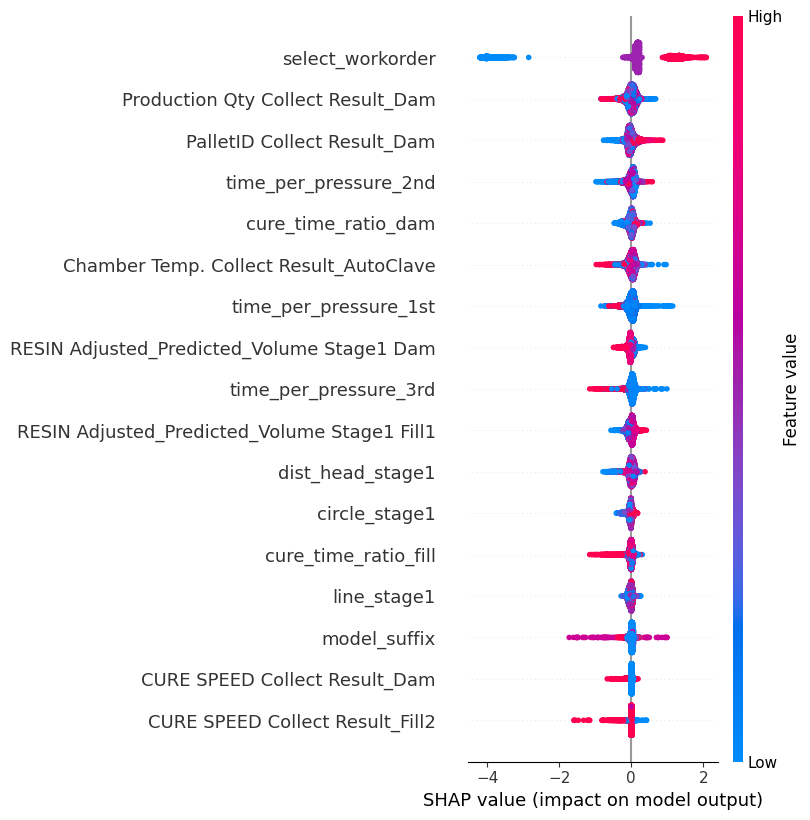

In [43]:
explainer = shap.Explainer(stage1_best_model)
shap_values = explainer(test_stage1_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage1_x)

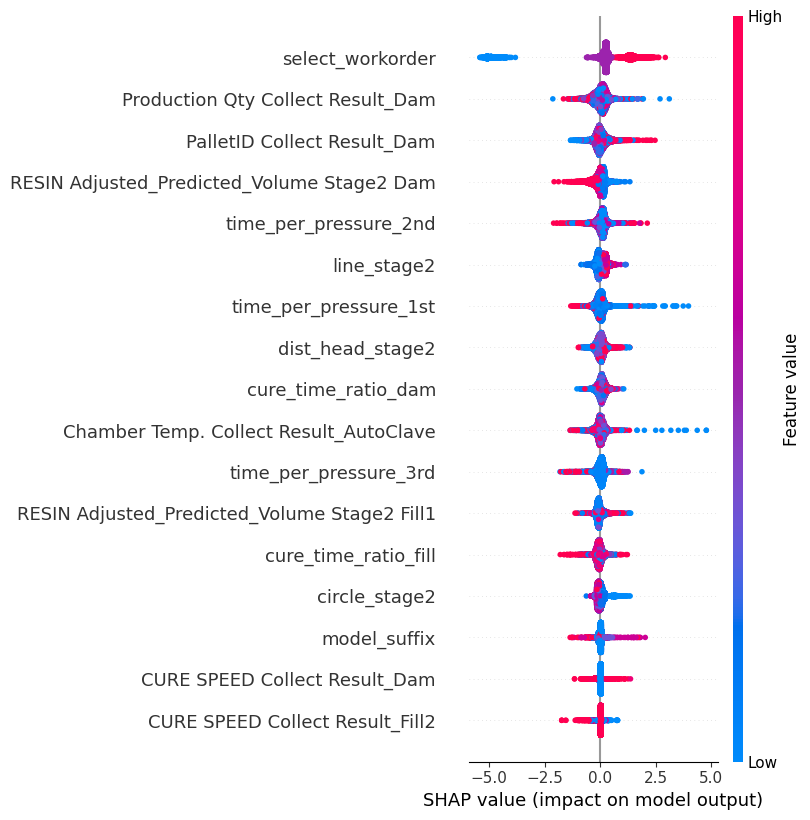

In [44]:
explainer = shap.Explainer(stage2_best_model)
shap_values = explainer(test_stage2_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage2_x)

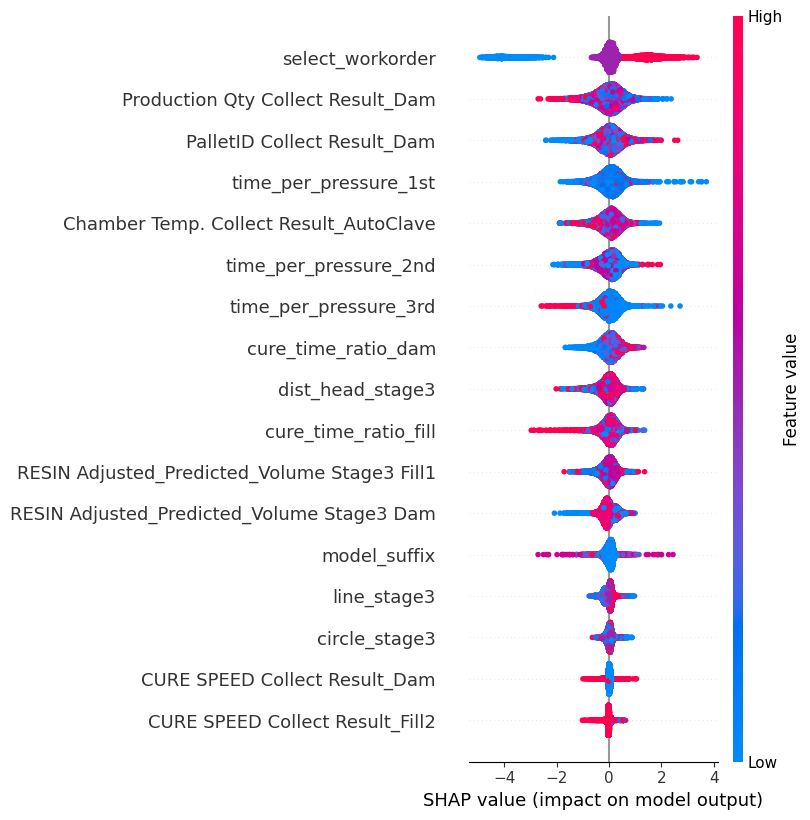

In [45]:
explainer = shap.Explainer(stage3_best_model)
shap_values = explainer(test_stage3_x)
shap.initjs()

shap.summary_plot(shap_values, test_stage3_x)

In [46]:
stage1_test_pred = stage1_best_model.predict(test_stage1_x)
stage1_test_pred

array([1, 0, 0, ..., 0, 0, 0])

In [47]:
stage2_test_pred = stage2_best_model.predict(test_stage2_x)
stage2_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
stage3_test_pred = stage3_best_model.predict(test_stage3_x)
stage3_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
result = np.logical_or(stage1_test_pred, stage2_test_pred)
result = np.logical_or(result, stage3_test_pred)

In [50]:
y_pred = np.where(result == 1, "AbNormal", "Normal")

In [51]:
np.unique(y_pred, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([  907, 16454]))

In [52]:
test['target'] = y_pred

In [53]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,901,16432
1,6,22


In [54]:
test['target'] = np.where(test['inconsistant'] == 1, 'AbNormal', test['target'])

In [55]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,901,16432
1,28,0


In [56]:
test.columns

Index(['Set ID', 'inconsistant', 'dist_head_stage1', 'dist_head_stage2',
       'dist_head_stage3', 'RESIN Adjusted_Predicted_Volume Stage1 Dam',
       'RESIN Adjusted_Predicted_Volume Stage2 Dam',
       'RESIN Adjusted_Predicted_Volume Stage3 Dam',
       'RESIN Adjusted_Predicted_Volume Stage1 Fill1',
       'RESIN Adjusted_Predicted_Volume Stage2 Fill1',
       'RESIN Adjusted_Predicted_Volume Stage3 Fill1', 'time_per_pressure_1st',
       'time_per_pressure_2nd', 'time_per_pressure_3rd', 'circle_stage1',
       'circle_stage2', 'circle_stage3', 'line_stage1', 'line_stage2',
       'line_stage3', 'cure_time_ratio_fill', 'cure_time_ratio_dam',
       'select_workorder', 'CURE SPEED Collect Result_Dam',
       'CURE SPEED Collect Result_Fill2', 'PalletID Collect Result_Dam',
       'Production Qty Collect Result_Dam',
       'Chamber Temp. Collect Result_AutoClave', 'model_suffix', 'target'],
      dtype='object')

<Axes: >

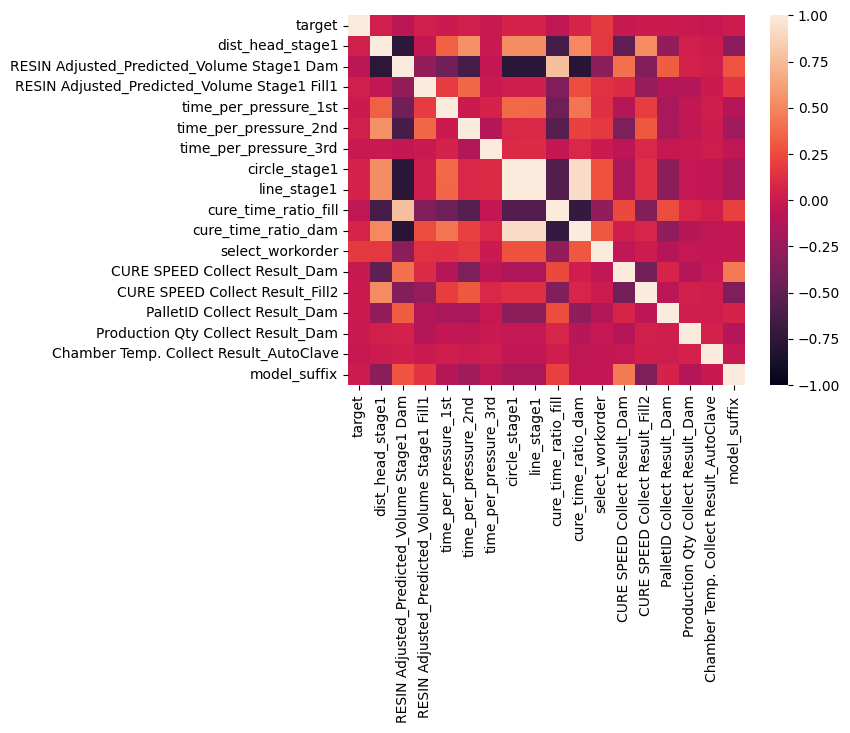

In [57]:
sns.heatmap(df_stage1.corr(), vmin=-1, vmax=1)

<Axes: >

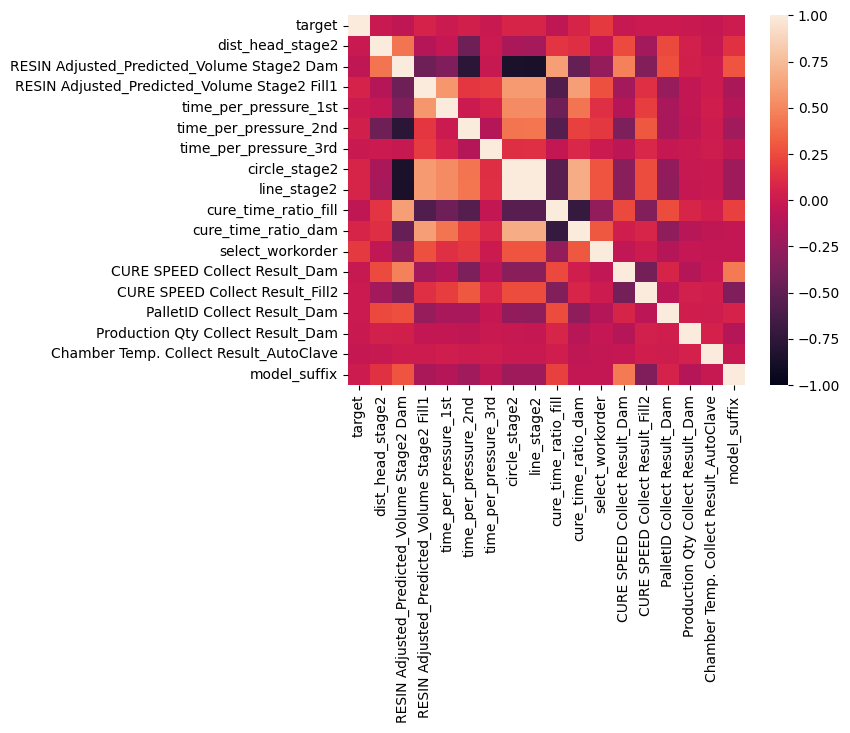

In [58]:
sns.heatmap(df_stage2.corr(), vmin=-1, vmax=1)

<Axes: >

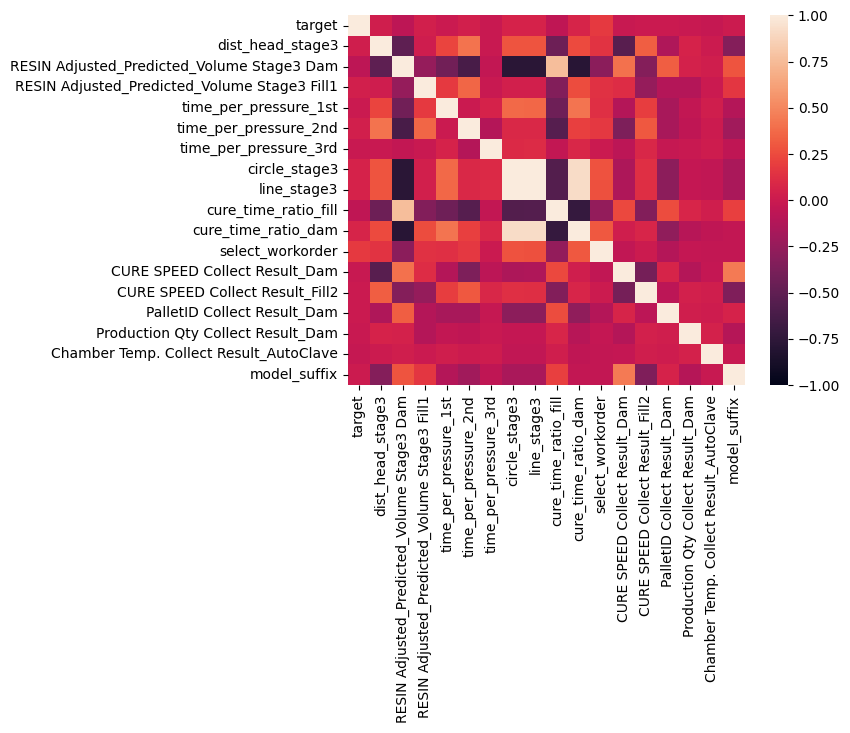

In [59]:
sns.heatmap(df_stage3.corr(), vmin=-1, vmax=1)

<Axes: >

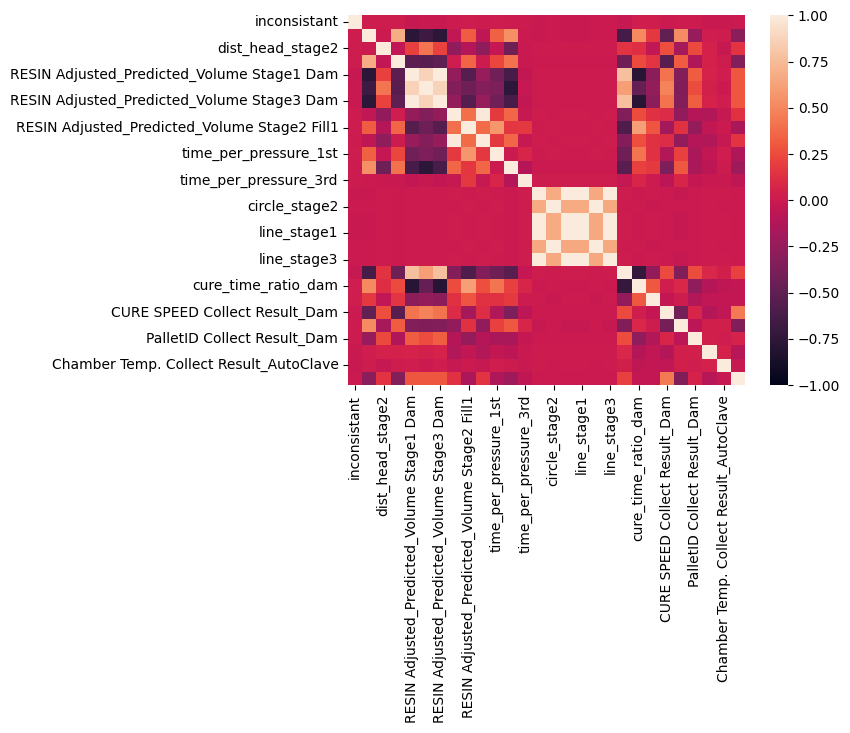

In [60]:
sns.heatmap(test.iloc[:, 1:-1].corr(), vmin=-1, vmax=1)

In [61]:
# # 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
# df_sub = pd.read_csv("submission.csv")
# df_sub["target"] = y_pred

# # 제출 파일 저장
# df_sub.to_csv("submission.csv", index=False)